In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import time
import datetime
import sys
import sklearn
import scipy.stats as stats
import feature_engine
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ===================== LOAD DATA =====================
df = pd.read_csv('creditcard.csv')

# If these rows exist, they will be dropped; if not, no error
df = df.drop(index=[150000, 150001], errors='ignore')
df = df.drop(columns = ['MonthlyIncome.1'],errors = 'ignore')

print(df.head())
print(df.info())

   NPA Status  RevolvingUtilizationOfUnsecuredLines   age  Gender Region  \
0         1.0                              0.766127  45.0    Male  South   
1         0.0                              0.957151  40.0  Female  South   
2         0.0                              0.658180  38.0  Female  South   
3         0.0                              0.233810  30.0  Female  South   
4         0.0                              0.907239  49.0    Male  South   

   MonthlyIncome Rented_OwnHouse Occupation     Education  \
0         9120.0        Ownhouse   Self_Emp        Matric   
1         2600.0        Ownhouse   Self_Emp      Graduate   
2         3042.0        Ownhouse   Self_Emp           PhD   
3         3300.0        Ownhouse   Self_Emp  Professional   
4        63588.0        Ownhouse   Self_Emp     Post-Grad   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  \
0                                   2.0   0.802982   
1                                   0.0   0.121876   
2             

In [3]:
# ===================== TRAIN-TEST SPLIT =====================
# Last column is Good_Bad as per your schema
x = df.iloc[:, :-1]          # all features except Good_Bad
y = df.iloc[:, -1]           # Good_Bad

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=11, stratify=y
)

print(f"Train shape: {x_train.shape}")
print(f"Test shape : {x_test.shape}")

# Make copies so we don't accidentally modify views
x_train = x_train.copy()
x_test = x_test.copy()


Train shape: (135000, 16)
Test shape : (15000, 16)


In [4]:
# ===================== HELPER: IMPUTATION FUNCTION =====================
def add_impute_versions(df, col, mean_val, med_val, mode_val):
    """
    Create col_mean, col_median, col_mode based on given statistics.
    """
    df[col + '_mean'] = df[col].fillna(mean_val)
    df[col + '_median'] = df[col].fillna(med_val)
    df[col + '_mode'] = df[col].fillna(mode_val)
    return df

In [5]:
# ===================== MONTHLY INCOME HANDLING =====================
# Compute statistics only from TRAIN
mean_MonthlyIncome   = x_train['MonthlyIncome'].mean()
median_MonthlyIncome = x_train['MonthlyIncome'].median()
mode_MonthlyIncome   = x_train['MonthlyIncome'].mode()[0]

In [6]:
# --- TRAIN: create mean/median/mode, keep mode version ---
x_train = add_impute_versions(
    x_train,
    'MonthlyIncome',
    mean_MonthlyIncome,
    median_MonthlyIncome,
    mode_MonthlyIncome
)


In [7]:
# keep MonthlyIncome_mode; drop raw + extra versions
x_train.drop(['MonthlyIncome', 'MonthlyIncome_mean', 'MonthlyIncome_median'], axis=1, inplace=True)

# --- TEST: impute, create MonthlyIncome_mode, drop original ---
x_test['MonthlyIncome'] = x_test['MonthlyIncome'].fillna(mode_MonthlyIncome)
x_test['MonthlyIncome_mode'] = x_test['MonthlyIncome']
x_test.drop(['MonthlyIncome'], axis=1, inplace=True)


In [8]:
# ===================== NumberOfDependents HANDLING =====================
# TRAIN: convert to numeric and create imputation variants
x_train['NumberOfDependents'] = pd.to_numeric(x_train['NumberOfDependents'])

number_mean   = x_train['NumberOfDependents'].mean()
number_median = x_train['NumberOfDependents'].median()
number_mode   = x_train['NumberOfDependents'].mode()[0]

x_train = add_impute_versions(
    x_train,
    'NumberOfDependents',
    number_mean,
    number_median,
    number_mode
)

In [9]:
# keep NumberOfDependents_median as per your previous logic
x_train.drop(
    ['NumberOfDependents','NumberOfDependents_mean','NumberOfDependents_mode'],
    axis=1,
    inplace=True
)

In [10]:
# TEST: convert to numeric, fill with train median, copy to *_median
x_test['NumberOfDependents'] = pd.to_numeric(x_test['NumberOfDependents'])
x_test['NumberOfDependents'] = x_test['NumberOfDependents'].fillna(number_median)
x_test['NumberOfDependents_median'] = x_test['NumberOfDependents']
x_test.drop(['NumberOfDependents'], axis=1, inplace=True)

In [11]:
# ===================== NUMERICAL FEATURES: LOG + 5–95% CAPPING =====================
# Now numerical columns are the same in both train & test
numerical_x_train = x_train.select_dtypes(exclude='object').copy()
numerical_x_test  = x_test.select_dtypes(exclude='object').copy()

numeric_cols = numerical_x_train.columns.tolist()
print("Numeric columns used:", numeric_cols)

Numeric columns used: ['NPA Status', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'MonthlyIncome_mode', 'NumberOfDependents_median']


In [12]:
# Log-transform all numeric features
for col in numeric_cols:
    numerical_x_train[col + '_log'] = np.log(numerical_x_train[col] + 1)
    numerical_x_test[col + '_log']  = np.log(numerical_x_test[col] + 1)


In [13]:
# 5th and 95th percentile capping on log features
for col in numeric_cols:
    col_log = col + '_log'
    upper = numerical_x_train[col_log].quantile(0.95)
    lower = numerical_x_train[col_log].quantile(0.05)

    numerical_x_train[col_log + '_5th'] = np.where(
        numerical_x_train[col_log] > upper, upper,
        np.where(numerical_x_train[col_log] < lower, lower, numerical_x_train[col_log])
    )

    numerical_x_test[col_log + '_5th'] = np.where(
        numerical_x_test[col_log] > upper, upper,
        np.where(numerical_x_test[col_log] < lower, lower, numerical_x_test[col_log])
    )


In [14]:
# Choose final numeric features (similar to what you ended up with)
numeric_final_features = [
    'RevolvingUtilizationOfUnsecuredLines_log_5th',
    'age_log_5th',
    'DebtRatio_log_5th',
    'NumberOfOpenCreditLinesAndLoans_log_5th',
    'NumberRealEstateLoansOrLines_log_5th',
    'MonthlyIncome_mode_log_5th',
    'NumberOfDependents_median_log_5th'
]

In [15]:
numerical_x_train = numerical_x_train[numeric_final_features].copy()
numerical_x_test  = numerical_x_test[numeric_final_features].copy()

print("Final numeric train shape:", numerical_x_train.shape)
print("Final numeric test shape :", numerical_x_test.shape)


Final numeric train shape: (135000, 7)
Final numeric test shape : (15000, 7)


In [16]:
# ===================== CATEGORICAL ENCODING =====================
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

categorical_x_train = x_train.select_dtypes(include='object').copy()
categorical_x_test  = x_test.select_dtypes(include='object').copy()

In [17]:
# ---------- Gender: OneHotEncoder (binary: Female/Male) ----------
one_hot_gender = OneHotEncoder(handle_unknown='ignore')
one_hot_gender.fit(categorical_x_train[['Gender']])

gender_train = one_hot_gender.transform(categorical_x_train[['Gender']]).toarray()
gender_test  = one_hot_gender.transform(categorical_x_test[['Gender']]).toarray()

In [18]:
# Assume 2 categories -> [:,1] is "male" (same as your earlier code)
categorical_x_train['Gender_male'] = gender_train[:, 1].astype(int)
categorical_x_test['Gender_male']  = gender_test[:, 1].astype(int)

In [19]:
# ---------- Region: OneHotEncoder ----------
one_hot_region = OneHotEncoder(handle_unknown='ignore')
one_hot_region.fit(categorical_x_train[['Region']])

region_train = one_hot_region.transform(categorical_x_train[['Region']]).toarray()
region_test  = one_hot_region.transform(categorical_x_test[['Region']]).toarray()

region_categories = list(one_hot_region.categories_[0])  # e.g. ['Central','East','North','South']
for i, cat in enumerate(region_categories):
    categorical_x_train[cat] = region_train[:, i].astype(int)
    categorical_x_test[cat]  = region_test[:, i].astype(int)

In [20]:
# ---------- Rented_OwnHouse: Ordinal ----------
od_rented = OrdinalEncoder()
od_rented.fit(categorical_x_train[['Rented_OwnHouse']])

categorical_x_train['Rented'] = od_rented.transform(categorical_x_train[['Rented_OwnHouse']]).astype(int)
categorical_x_test['Rented']  = od_rented.transform(categorical_x_test[['Rented_OwnHouse']]).astype(int)

In [21]:
# ---------- Occupation: Ordinal ----------
od_occ = OrdinalEncoder()
od_occ.fit(categorical_x_train[['Occupation']])

categorical_x_train['Occupation_re'] = od_occ.transform(categorical_x_train[['Occupation']]).astype(int)
categorical_x_test['Occupation_re']  = od_occ.transform(categorical_x_test[['Occupation']]).astype(int)



In [22]:
# ---------- Education: Ordinal ----------
od_edu = OrdinalEncoder()
od_edu.fit(categorical_x_train[['Education']])

categorical_x_train['Education_re'] = od_edu.transform(categorical_x_train[['Education']]).astype(int)
categorical_x_test['Education_re']  = od_edu.transform(categorical_x_test[['Education']]).astype(int)

In [23]:
# Drop original categorical columns (keep only encoded versions)
categorical_x_train.drop(['Gender','Region','Rented_OwnHouse','Occupation','Education'], axis=1, inplace=True)
categorical_x_test.drop(['Gender','Region','Rented_OwnHouse','Occupation','Education'], axis=1, inplace=True)

print("Categorical train cols:", categorical_x_train.columns.tolist())
print("Categorical test cols :", categorical_x_test.columns.tolist())


Categorical train cols: ['Gender_male', 'Central', 'East', 'North', 'South', 'West', 'Rented', 'Occupation_re', 'Education_re']
Categorical test cols : ['Gender_male', 'Central', 'East', 'North', 'South', 'West', 'Rented', 'Occupation_re', 'Education_re']


In [24]:
# ===================== MERGE NUMERIC + CATEGORICAL =====================
x_train_final = pd.concat([numerical_x_train, categorical_x_train], axis=1)
x_test_final  = pd.concat([numerical_x_test,  categorical_x_test],  axis=1)

# Ensure same column order
x_test_final = x_test_final[x_train_final.columns]

print("Final train feature shape:", x_train_final.shape)
print("Final test feature shape :", x_test_final.shape)

Final train feature shape: (135000, 16)
Final test feature shape : (15000, 16)


In [25]:
# ===================== LABEL ENCODING TARGET =====================
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
y_train_enc = lb.fit_transform(y_train)
y_test_enc  = lb.transform(y_test)

In [26]:
# ===================== SCALING =====================
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train_final)
x_test_scaled  = sc.transform(x_test_final)

In [27]:
# ===================== MODEL TRAINING & EVALUATION =====================
def KNN(x_train,y_train,x_test,y_test):
    reg_knn = KNeighborsClassifier(n_neighbors=5)
    reg_knn.fit(x_train,y_train)
    print('----KNN----')
    print(f'Train acc : {reg_knn.score(x_train,y_train)}')
    print(f'Test acc  : {reg_knn.score(x_test,y_test)}')
    print('Confusion matrix:\n', confusion_matrix(y_test, reg_knn.predict(x_test)))
    print('Classification report:\n', classification_report(y_test, reg_knn.predict(x_test)))
    return reg_knn

In [28]:
def NB(x_train,y_train,x_test,y_test):
    reg_nb = GaussianNB()
    reg_nb.fit(x_train,y_train)
    print('----Naive Bayes----')
    print(f'Train acc : {reg_nb.score(x_train,y_train)}')
    print(f'Test acc  : {reg_nb.score(x_test,y_test)}')
    print('Confusion matrix:\n', confusion_matrix(y_test, reg_nb.predict(x_test)))
    print('Classification report:\n', classification_report(y_test, reg_nb.predict(x_test)))
    return reg_nb

In [29]:
def LR_model(x_train,y_train,x_test,y_test):
    reg_lr = LogisticRegression()
    reg_lr.fit(x_train,y_train)
    print('----Logistic Regression----')
    print(f'Train acc : {reg_lr.score(x_train,y_train)}')
    print(f'Test acc  : {reg_lr.score(x_test,y_test)}')
    print('Confusion matrix:\n', confusion_matrix(y_test, reg_lr.predict(x_test)))
    print('Classification report:\n', classification_report(y_test, reg_lr.predict(x_test)))
    return reg_lr

In [30]:
def DT(x_train,y_train,x_test,y_test):
    reg_dt = DecisionTreeClassifier(criterion='entropy')
    reg_dt.fit(x_train,y_train)
    print('----Decision Tree----')
    print(f'Train acc : {reg_dt.score(x_train,y_train)}')
    print(f'Test acc  : {reg_dt.score(x_test,y_test)}')
    print('Confusion matrix:\n', confusion_matrix(y_test, reg_dt.predict(x_test)))
    print('Classification report:\n', classification_report(y_test, reg_dt.predict(x_test)))
    return reg_dt

In [31]:
def RF(x_train,y_train,x_test,y_test):
    reg_rf = RandomForestClassifier(n_estimators=5, random_state=42)
    reg_rf.fit(x_train,y_train)
    print('----Random Forest----')
    print(f'Train acc : {reg_rf.score(x_train,y_train)}')
    print(f'Test acc  : {reg_rf.score(x_test,y_test)}')
    print('Confusion matrix:\n', confusion_matrix(y_test, reg_rf.predict(x_test)))
    print('Classification report:\n', classification_report(y_test, reg_rf.predict(x_test)))
    return reg_rf

In [32]:
# Train all and pick the one you like (I'll keep NB as final like you did)
knn_model = KNN(x_train_scaled, y_train_enc, x_test_scaled, y_test_enc)
nb_model  = NB(x_train_scaled, y_train_enc, x_test_scaled, y_test_enc)
lr_model  = LR_model(x_train_scaled, y_train_enc, x_test_scaled, y_test_enc)
dt_model  = DT(x_train_scaled, y_train_enc, x_test_scaled, y_test_enc)
rf_model  = RF(x_train_scaled, y_train_enc, x_test_scaled, y_test_enc)

----KNN----
Train acc : 0.9514074074074074
Test acc  : 0.9420666666666667
Confusion matrix:
 [[  291   712]
 [  157 13840]]
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.29      0.40      1003
           1       0.95      0.99      0.97     13997

    accuracy                           0.94     15000
   macro avg       0.80      0.64      0.69     15000
weighted avg       0.93      0.94      0.93     15000

----Naive Bayes----
Train acc : 0.8753333333333333
Test acc  : 0.8775333333333334
Confusion matrix:
 [[  571   432]
 [ 1405 12592]]
Classification report:
               precision    recall  f1-score   support

           0       0.29      0.57      0.38      1003
           1       0.97      0.90      0.93     13997

    accuracy                           0.88     15000
   macro avg       0.63      0.73      0.66     15000
weighted avg       0.92      0.88      0.90     15000

----Logistic Regression----
Train acc : 0.

In [33]:
# ===================== ROC CURVES (Optional) =====================
from sklearn.metrics import roc_curve

In [34]:
# Here still using class labels as in your original code
y_pred_knn = knn_model.predict(x_test_scaled)
y_pred_nb  = nb_model.predict(x_test_scaled)
y_pred_lr  = lr_model.predict(x_test_scaled)
y_pred_dt  = dt_model.predict(x_test_scaled)
y_pred_rf  = rf_model.predict(x_test_scaled)

In [35]:
fprk, tprk, _ = roc_curve(y_test_enc, y_pred_knn)
fprn, tprn, _ = roc_curve(y_test_enc, y_pred_nb)
fprl, tprl, _ = roc_curve(y_test_enc, y_pred_lr)
fprd, tprd, _ = roc_curve(y_test_enc, y_pred_dt)
fprr, tprr, _ = roc_curve(y_test_enc, y_pred_rf)

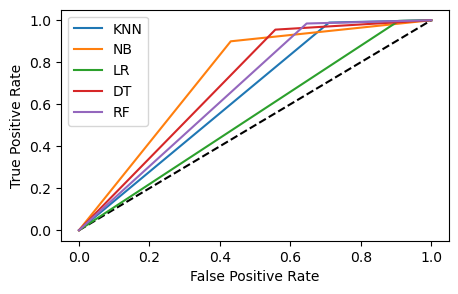

In [36]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fprk,tprk,label='KNN')
plt.plot(fprn,tprn,label='NB')
plt.plot(fprl,tprl,label='LR')
plt.plot(fprd,tprd,label='DT')
plt.plot(fprr,tprr,label='RF')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=0)
plt.show()


In [37]:
# ===================== SAVE FINAL MODEL FOR DEPLOYMENT =====================
import pickle

In [38]:
# Choose NB as final (you can change to rf_model, lr_model etc.)
final_model = nb_model

In [39]:
deploy_dict = {
    "model": final_model,
    "scaler": sc,
    "one_hot_gender": one_hot_gender,
    "one_hot_region": one_hot_region,
    "ordinal_rented": od_rented,
    "ordinal_occupation": od_occ,
    "ordinal_education": od_edu,
    "mode_MonthlyIncome": mode_MonthlyIncome,
    "median_NumberOfDependents": number_median,
    "label_encoder": lb,
    "feature_names": list(x_train_final.columns)
}

In [40]:
with open('credit_final_model.pkl', 'wb') as f:
    pickle.dump(deploy_dict, f)

print("✅ Model and preprocessing pipeline saved to credit_final_model.pkl")

✅ Model and preprocessing pipeline saved to credit_final_model.pkl
